### This script relies on a active environment with Basemap
If that is not possible, you properly have to outcomment a thing or two.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import ezodf

In [2]:
airports_1 = gpd.read_file('Data Sources/Global Airports Shapefile (1)/ne_10m_airports.shp')
ports_1 = gpd.read_file('Data Sources/Global Ports Shapefile (1)/WPI.shp')
countries = gpd.read_file('Data Sources/countries (1)/ne_50m_admin_0_countries.shp').fillna(value='None')
globalFreight = pd.read_csv('Data Sources/Global Air Freight (1)/Air_Transported_Goods.csv',header=2).fillna(value=0)
globalPassengers = pd.read_csv('Data Sources/Global Passengers Carried (1)/Passengers_Carried.csv',header=2).fillna(value=0)

### Let's have a look at the first shapefile

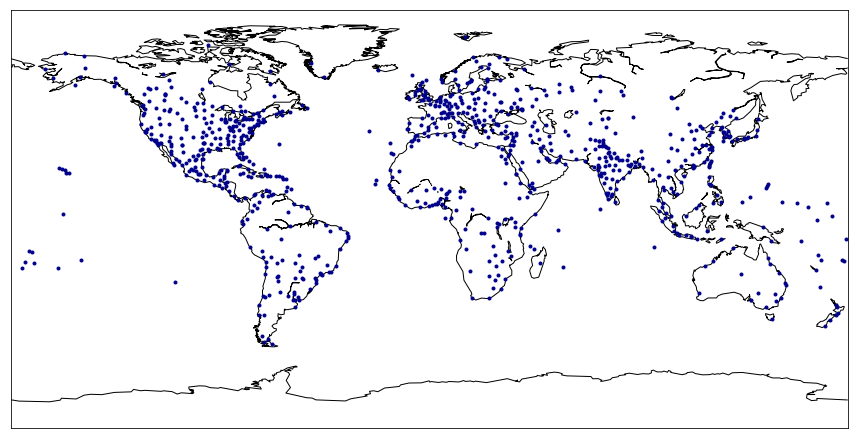

In [3]:
##### Visualising the airports
plt.figure(figsize=(15,15))
map = Basemap()
map.drawcoastlines()

for airport in airports_1.index:
    map.plot(list(airports_1.loc[airport].geometry.coords)[0][0],
            list(airports_1.loc[airport].geometry.coords)[0][1],color='darkblue',marker='o',markersize=3)

plt.show()

In [4]:
airports_1.shape

(891, 36)

In [5]:
airports_1.columns

Index(['scalerank', 'featurecla', 'type', 'name', 'abbrev', 'location',
       'gps_code', 'iata_code', 'wikipedia', 'natlscale', 'comments',
       'wikidataid', 'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es',
       'name_fr', 'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it',
       'name_ja', 'name_ko', 'name_nl', 'name_pl', 'name_pt', 'name_ru',
       'name_sv', 'name_tr', 'name_vi', 'name_zh', 'wdid_score', 'ne_id',
       'geometry'],
      dtype='object')

In [6]:
airports_1.location.unique()

array(['terminal', 'ramp', 'runway', 'approximate', 'parking', 'freight'],
      dtype=object)

In [7]:
{airportLocation:sum([1 if thisLocation == airportLocation else 0 for thisLocation in airports_1['location']])\
 for airportLocation in airports_1['location'].unique()}

{'terminal': 782,
 'ramp': 56,
 'runway': 37,
 'approximate': 8,
 'parking': 7,
 'freight': 1}

In [8]:
# Removed columns are 'featurecla' (not varity) and all the name-columns in different languages. 
airports = airports_1[['scalerank','type','name','abbrev','location','gps_code','iata_code','wikipedia',\
                      'wdid_score','ne_id','geometry']]

In [9]:
# Alternating the iso codes, because some have a iso_code of -99 (Because it isn't a sovereign state)
# http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-details/
# https://unstats.un.org/unsd/tradekb/Knowledgebase/Country-Code

In [10]:
countries.shape

(241, 95)

In [11]:
iso_codes = []
for iso,name,sov in zip(countries.ISO_A3,countries.NAME,countries.SOV_A3):
    if (iso == '-99') and (name != 'France'):
        print(name,sov)
        iso_codes.append(sov)
    elif (iso == '-99') and (name == 'France'):
        iso_codes.append('FRA')
    else:
        iso_codes.append(iso)
        
countries['ISO3'] = np.array(iso_codes).astype('object') 

Somaliland SOL
Norway NOR
Kosovo KOS
N. Cyprus CYN
Indian Ocean Ter. AU1
Ashmore and Cartier Is. AU1
Siachen Glacier KAS


In [12]:
airports = gpd.sjoin(airports,countries, how='left',op = 'within')
airports = airports[['scalerank_left','type','name','abbrev','location','gps_code','iata_code','wikipedia',\
                      'wdid_score','ne_id','geometry','NAME','ISO3']]

In [13]:
airports.head()

,scalerank_left,type,name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,NAME,ISO3
0,9,small,Sahnewal,LUH,terminal,VILD,LUH,http://en.wikipedia.org/wiki/Sahnewal_Airport,4,1159113785,POINT (75.95707224036518 30.85035985617018),India,IND
1,9,mid,Solapur,SSE,terminal,VASL,SSE,http://en.wikipedia.org/wiki/Solapur_Airport,4,1159113803,POINT (75.93305977107549 17.62541518363502),India,IND
2,9,mid,Birsa Munda,IXR,terminal,VERC,IXR,http://en.wikipedia.org/wiki/Birsa_Munda_Airport,4,1159113831,POINT (85.32359703687671 23.31772459899619),India,IND
3,9,mid,Ahwaz,AWZ,terminal,OIAW,AWZ,http://en.wikipedia.org/wiki/Ahwaz_Airport,4,1159113845,POINT (48.74710654359313 31.34315855607572),Iran,IRN
4,9,mid and military,Gwalior,GWL,terminal,VIGR,GWL,http://en.wikipedia.org/wiki/Gwalior_Airport,4,1159113863,POINT (78.21721865463483 26.28548769793701),India,IND


In [14]:
airports.NAME = np.array(airports.NAME.fillna('None'))
airports.ISO3 = np.array(airports.ISO3.fillna('None'))

In [15]:
print('The number of airports with missing country-specification are: ',\
     sum([1 if name == 'None' else 0 for name in airports.NAME]),
     '\nThe total number of airports are: ',airports.shape[0],
     '\nWhich is %.3f percentage of the airports' %((sum([1 if name == 'None' else 0 for name in airports.NAME])\
                                                    /airports.shape[0])*100))

The number of airports with missing country-specification are:  68 
The total number of airports are:  891 
Which is 7.632 percentage of the airports


### Let's investigate airports with missing country-specifications

In [16]:
noCountryAirports = airports[[True if name == 'None' else False for name in airports.NAME]]
noCountryAirports = noCountryAirports.reset_index(drop=True)

In [17]:
noCountryAirports

,scalerank_left,type,name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,NAME,ISO3
0,8,mid,Cocos (Keeling) Islands,CCK,terminal,YPCC,CCK,http://en.wikipedia.org/wiki/Cocos_(Keeling)_I...,4,1159115105,POINT (96.82874721442073 -12.18515859532931),None,None
1,8,mid,Corfu Int'l (Ioannis Kapodistrias),CFU,terminal,LGKR,CFU,http://en.wikipedia.org/wiki/Corfu_Internation...,4,1159115125,POINT (19.91475616416621 39.60675545052586),None,None
2,8,mid,Gerrard Smith,CYB,terminal,MWCB,CYB,http://en.wikipedia.org/wiki/Gerrard_Smith_Int...,4,1159115383,POINT (-79.87946163800297 19.68986539628435),None,None
3,8,mid,Terrance B. Lettsome Int'l,EIS,terminal,TUPJ,EIS,http://en.wikipedia.org/wiki/Terrance_B._Letts...,4,1159115573,POINT (-64.53715143657945 18.44436185579831),None,None
4,8,mid,Gibraltar,GIB,runway,LXGB,GIB,http://en.wikipedia.org/wiki/Gibraltar_Airport,4,1159115799,POINT (-5.346771800333878 36.15127475041734),None,None
5,8,mid,Sumburgh,LSI,runway,EGPB,LSI,http://en.wikipedia.org/wiki/Sumburgh_Airport,2,1159116567,POINT (-1.288060688387535 59.87668995989993),None,None
6,8,mid,Svalbard Longyear,LYR,terminal,ENSB,LYR,http://en.wikipedia.org/wiki/Svalbard_Airport%...,4,1159116623,POINT (15.495229 78.246717),None,None
7,8,major,Paphos Int'l,PFO,ramp,LCPH,PFO,http://en.wikipedia.org/wiki/Paphos_Internatio...,4,1159116971,POINT (32.48323220649264 34.71340128173351),None,None
8,8,mid,Sitka Rocky Gutierrez,SIT,terminal,PASI,SIT,http://en.wikipedia.org/wiki/Sitka_Rocky_Gutie...,4,1159117325,POINT (-135.365692 57.05349),None,None
9,8,major,Shannon,SNN,terminal,EINN,SNN,http://en.wikipedia.org/wiki/Shannon_Airport,4,1159117403,POINT (-8.922428855576857 52.69345371025317),None,None


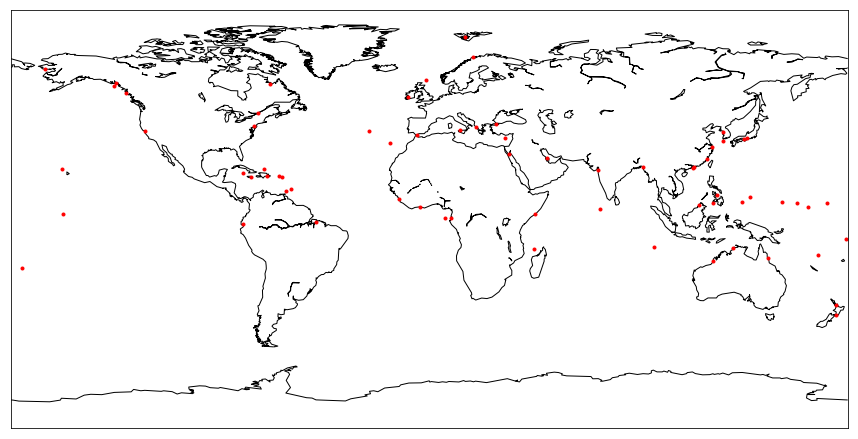

In [18]:
##### Visualising the airports
plt.figure(figsize=(15,15))
map = Basemap()
map.drawcoastlines()

for airport in noCountryAirports.index:
    map.plot(list(noCountryAirports.loc[airport].geometry.coords)[0][0],
            list(noCountryAirports.loc[airport].geometry.coords)[0][1],color='red',marker='o',markersize=3)

plt.show()

The reason for some airports not being assigned as ISO3 code, is because the codes are assigned based on the intersection with the country-polygons. There are two reasons why they don't intersect with the country-shapfile; 

1: Some airports are located on remote islands, which aren't in the country-shapefile.
2: The points of the airports are, from the origin, calculated as the centroid of the airport area, which can apperently lie out in the sea, which implies that it isn't captured by the intersection with the countries.

It is not prioritised at the moment.

### Write the files

In [19]:
# Based on this answer: https://gis.stackexchange.com/questions/159681/geopandas-cant-save-geojson
with open('Final Data/airports.geojson', 'w') as f:
    f.write(airports.to_json())

In [20]:
airportsToSave = airports.drop(['geometry'],axis=1)
airportsToSave.to_csv('Final Data/Airports.csv')

### Let's take a look at the UK Data

In [21]:
UKAirportsFreight = pd.read_csv('Data Sources/UK Airport Data (2)/Table_13_Freight_by_Type_and_Nationality(1).csv',
                                parse_dates = ['rundate'])
UKAirportsFreight = UKAirportsFreight.drop(['rundate','reporting_period'],axis=1)

In [22]:
UKAirportsFreight = UKAirportsFreight.sort_values(by=['total_freight'],ascending = False)
UKAirportsFreight = UKAirportsFreight.reset_index(drop=True)
topFiveUKAirports = UKAirportsFreight.loc[0:4]

In [23]:
UKAirportsFreight.head()

,reporting_airport_group_name,reporting_airport_name,total_freight,freight_set_down_scheduled_UK,freight_picked_up_scheduled_UK,freight_set_down_scheduled_foreign_EU,freight_picked_up_scheduled_foreign_EU,freight_set_down_scheduled_foreign_non_EU,freight_picked_up_scheduled_foreign_non_EU,freight_set_down_charter_UK,freight_picked_up_charter_UK,freight_set_down_charter_foreign_EU,freight_picked_up_charter_foreign_EU,freight_set_down_charter_foreign_non_EU,freight_picked_up_charter_foreign_non_EU
0,London Area Airports,HEATHROW,128064.672,23871.258,29608.274,2931.209,2370.728,33903.267,35379.936,0.000,0.000,0.000,0.00,0.000,0.000
1,Other UK Airports,EAST MIDLANDS INTERNATIONAL,24427.571,1151.708,1027.371,3671.294,4317.857,2260.787,1850.626,2.043,0.000,4906.103,5151.56,67.556,20.666
2,London Area Airports,STANSTED,14591.857,240.881,21.150,924.600,256.402,7503.910,5582.581,0.000,0.000,0.000,0.00,62.333,0.000
3,London Area Airports,GATWICK,8608.969,1601.790,4120.024,18.855,32.633,1056.073,1616.481,98.721,64.392,0.000,0.00,0.000,0.000
4,Other UK Airports,MANCHESTER,7747.965,238.615,481.956,56.314,44.409,3581.368,3269.226,37.848,17.283,1.260,0.00,0.001,19.685


In [24]:
topFiveUKAirports

,reporting_airport_group_name,reporting_airport_name,total_freight,freight_set_down_scheduled_UK,freight_picked_up_scheduled_UK,freight_set_down_scheduled_foreign_EU,freight_picked_up_scheduled_foreign_EU,freight_set_down_scheduled_foreign_non_EU,freight_picked_up_scheduled_foreign_non_EU,freight_set_down_charter_UK,freight_picked_up_charter_UK,freight_set_down_charter_foreign_EU,freight_picked_up_charter_foreign_EU,freight_set_down_charter_foreign_non_EU,freight_picked_up_charter_foreign_non_EU
0,London Area Airports,HEATHROW,128064.672,23871.258,29608.274,2931.209,2370.728,33903.267,35379.936,0.000,0.000,0.000,0.00,0.000,0.000
1,Other UK Airports,EAST MIDLANDS INTERNATIONAL,24427.571,1151.708,1027.371,3671.294,4317.857,2260.787,1850.626,2.043,0.000,4906.103,5151.56,67.556,20.666
2,London Area Airports,STANSTED,14591.857,240.881,21.150,924.600,256.402,7503.910,5582.581,0.000,0.000,0.000,0.00,62.333,0.000
3,London Area Airports,GATWICK,8608.969,1601.790,4120.024,18.855,32.633,1056.073,1616.481,98.721,64.392,0.000,0.00,0.000,0.000
4,Other UK Airports,MANCHESTER,7747.965,238.615,481.956,56.314,44.409,3581.368,3269.226,37.848,17.283,1.260,0.00,0.001,19.685


In [25]:
print('The top five UK airports are:\n')
[print(topFiveName.lower()) for topFiveName in topFiveUKAirports.reporting_airport_name]

print('\nHow many of the top five airports in UK are in the first shapefile? Answer:',
      sum([1 if any([True if topFiveName.lower() in name.lower() else False for name in airports.name])\
           else 0 for topFiveName in topFiveUKAirports.reporting_airport_name]))

The top five UK airports are:

heathrow
east midlands international
stansted
gatwick
manchester

How many of the top five airports in UK are in the first shapefile? Answer: 3


In [26]:
print('Which are the airports present?\n')
[print(topFiveName) if any([True if topFiveName.lower() in name.lower() else False for name in airports.name])\
           else 0 for topFiveName in topFiveUKAirports.reporting_airport_name]
print()

Which are the airports present?

HEATHROW
GATWICK
MANCHESTER



In [27]:
print('How many of the airports in UK are in the airport shapefile? Answer:',
      sum([1 if any([True if Name.lower() in name.lower() else False for name in airports.name])\
           else 0 for Name in UKAirportsFreight.reporting_airport_name]),
     '\nOut of of total of: ',UKAirportsFreight.shape[0])
print('\nWhich are the airports present?\n')
[print(Name) if any([True if Name.lower() in name.lower() else False for name in airports.name])\
           else 0 for Name in UKAirportsFreight.reporting_airport_name]
print()

How many of the airports in UK are in the airport shapefile? Answer: 11 
Out of of total of:  34

Which are the airports present?

HEATHROW
GATWICK
MANCHESTER
LUTON
BIRMINGHAM
EDINBURGH
GLASGOW
PRESTWICK
NEWCASTLE
SUMBURGH
KIRKWALL



In [28]:
# This beauty of a list comprehension looks for airports which matches the airports listed in 
# UKAirportsFreight while at the same time making sure that the located airports are located in United Kingdom.
# Note that with respect to the location of the airport, None is allowed because one airport, which is part of 
# UKAirportsFreight, doesn't have an ISO3 code. This is of cause not at all generic and should be allowed with caution.

airportsUK = airports[[True if (any([Name.lower() in name.lower() for Name in UKAirportsFreight.reporting_airport_name])) &\
                     (airports.ISO3.loc[i] in ['None','GBR'])else False for i,name in enumerate(airports.name)]]
airportsUK = airportsUK.reset_index(drop=True)

In [29]:
airportsUK

,scalerank_left,type,name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,NAME,ISO3
0,8,major,Newcastle Int'l,NCL,terminal,EGNT,NCL,http://en.wikipedia.org/wiki/Newcastle_Airport,4,1159114519,POINT (-1.71034578407216 55.03708486080195),United Kingdom,GBR
1,8,major,Edinburgh Int'l,EDI,terminal,EGPH,EDI,http://en.wikipedia.org/wiki/Edinburgh_Airport,4,1159115559,POINT (-3.364284685135545 55.9485540113639),United Kingdom,GBR
2,8,mid,Kirkwall,KOI,ramp,EGPA,KOI,http://en.wikipedia.org/wiki/Kirkwall_Airport,4,1159116405,POINT (-2.901378495245077 58.95442887883035),United Kingdom,GBR
3,8,mid,Sumburgh,LSI,runway,EGPB,LSI,http://en.wikipedia.org/wiki/Sumburgh_Airport,2,1159116567,POINT (-1.288060688387535 59.87668995989993),None,None
4,8,major,London Luton,LTN,terminal,EGGW,LTN,http://en.wikipedia.org/wiki/London_Luton_Airport,4,1159116605,POINT (-0.3762272673974393 51.8802952570969),United Kingdom,GBR
5,7,mid,Glasgow Prestwick,PIK,terminal,EGPK,PIK,http://en.wikipedia.org/wiki/Glasgow_Prestwick...,4,1159120173,POINT (-4.610971639010682 55.50889181051421),United Kingdom,GBR
6,6,major,London Gatwick,LGW,terminal,EGKK,LGW,http://en.wikipedia.org/wiki/London_Gatwick_Ai...,4,1159122245,POINT (-0.1629616391394559 51.15575675192746),United Kingdom,GBR
7,6,major,Manchester Int'l,MAN,terminal,EGCC,MAN,http://en.wikipedia.org/wiki/Manchester_Airport,4,1159122331,POINT (-2.273371590694274 53.36248960665181),United Kingdom,GBR
8,6,major,Birmingham Int'l,BHX,terminal,EGBB,BHX,http://en.wikipedia.org/wiki/Birmingham_Intern...,4,1159122687,POINT (-1.733731704344524 52.45290855428381),United Kingdom,GBR
9,4,major,Glasgow Int'l,GLA,terminal,EGPF,GLA,http://en.wikipedia.org/wiki/Glasgow_Internati...,4,1159125213,POINT (-4.431677969951069 55.86418285703546),United Kingdom,GBR


In [30]:
# Two things are needed; We need to reduce UKAirportsFreight, to only contain the relevant airports, and we need to attached 
# the iata_codes for the airports, based on the reduced dataframe airportsUK.

# First thing first, is to reduce the UKAirportsFreight.

UKAirportsFreightReduced = UKAirportsFreight[[True if any([name.lower() in Name.lower() for Name in airportsUK.name])\
                                             else False for name in UKAirportsFreight.reporting_airport_name]]
UKAirportsFreightReduced = UKAirportsFreightReduced.reset_index(drop=True)

# Extracing iata_codes
iata_codeFreight = []
for name in UKAirportsFreightReduced.reporting_airport_name:
    for Name,iata in zip(airportsUK['name'],airportsUK['iata_code']):
        if name.lower() in Name.lower():
            iata_codeFreight.append(iata)

In [31]:
# This separate code block is necessary because the procedure for allocation of iata codes above is unambigious.
del iata_codeFreight[5]
UKAirportsFreightReduced['iata_code'] = np.array(iata_codeFreight)

# Joining together the two reduced dataframes.
UKFrieghtAirports = UKAirportsFreightReduced.join(airportsUK.set_index('iata_code'),on=['iata_code'])

In [32]:
UKFrieghtAirports

,reporting_airport_group_name,reporting_airport_name,total_freight,freight_set_down_scheduled_UK,freight_picked_up_scheduled_UK,freight_set_down_scheduled_foreign_EU,freight_picked_up_scheduled_foreign_EU,freight_set_down_scheduled_foreign_non_EU,freight_picked_up_scheduled_foreign_non_EU,freight_set_down_charter_UK,...,name,abbrev,location,gps_code,wikipedia,wdid_score,ne_id,geometry,NAME,ISO3
0,London Area Airports,HEATHROW,128064.672,23871.258,29608.274,2931.209,2370.728,33903.267,35379.936,0.000,...,London Heathrow,LHR,parking,EGLL,http://en.wikipedia.org/wiki/London_Heathrow_A...,4,1159127237,POINT (-0.4531566520633094 51.47099587999384),United Kingdom,GBR
1,London Area Airports,GATWICK,8608.969,1601.790,4120.024,18.855,32.633,1056.073,1616.481,98.721,...,London Gatwick,LGW,terminal,EGKK,http://en.wikipedia.org/wiki/London_Gatwick_Ai...,4,1159122245,POINT (-0.1629616391394559 51.15575675192746),United Kingdom,GBR
2,Other UK Airports,MANCHESTER,7747.965,238.615,481.956,56.314,44.409,3581.368,3269.226,37.848,...,Manchester Int'l,MAN,terminal,EGCC,http://en.wikipedia.org/wiki/Manchester_Airport,4,1159122331,POINT (-2.273371590694274 53.36248960665181),United Kingdom,GBR
3,London Area Airports,LUTON,3062.702,0.000,0.000,2482.777,173.315,249.871,152.767,0.000,...,London Luton,LTN,terminal,EGGW,http://en.wikipedia.org/wiki/London_Luton_Airport,4,1159116605,POINT (-0.3762272673974393 51.8802952570969),United Kingdom,GBR
4,Other UK Airports,BIRMINGHAM,2145.088,14.071,12.889,74.611,44.148,1133.689,858.399,0.981,...,Birmingham Int'l,BHX,terminal,EGBB,http://en.wikipedia.org/wiki/Birmingham_Intern...,4,1159122687,POINT (-1.733731704344524 52.45290855428381),United Kingdom,GBR
5,Other UK Airports,EDINBURGH,1414.763,1.339,0.000,335.121,304.876,0.000,0.000,0.000,...,Glasgow Prestwick,PIK,terminal,EGPK,http://en.wikipedia.org/wiki/Glasgow_Prestwick...,4,1159120173,POINT (-4.610971639010682 55.50889181051421),United Kingdom,GBR
6,Other UK Airports,GLASGOW,989.495,4.424,36.796,5.684,8.309,153.620,780.515,0.115,...,Glasgow Int'l,GLA,terminal,EGPF,http://en.wikipedia.org/wiki/Glasgow_Internati...,4,1159125213,POINT (-4.431677969951069 55.86418285703546),United Kingdom,GBR
7,Other UK Airports,PRESTWICK,941.631,0.000,0.000,603.820,265.580,0.000,0.000,0.000,...,Glasgow Prestwick,PIK,terminal,EGPK,http://en.wikipedia.org/wiki/Glasgow_Prestwick...,4,1159120173,POINT (-4.610971639010682 55.50889181051421),United Kingdom,GBR
8,Other UK Airports,NEWCASTLE,231.021,0.008,0.000,0.059,0.056,26.750,159.845,0.000,...,Newcastle Int'l,NCL,terminal,EGNT,http://en.wikipedia.org/wiki/Newcastle_Airport,4,1159114519,POINT (-1.71034578407216 55.03708486080195),United Kingdom,GBR
9,Other UK Airports,SUMBURGH,18.588,12.117,0.537,0.000,0.000,0.000,0.000,2.283,...,Sumburgh,LSI,runway,EGPB,http://en.wikipedia.org/wiki/Sumburgh_Airport,2,1159116567,POINT (-1.288060688387535 59.87668995989993),None,None


In [33]:
cols = list(UKFrieghtAirports.columns)
# Restructuring the columns
cols_re = [cols[18]]+[cols[15]]+[cols[17]]+[cols[-2]]+[cols[-1]]+\
          [cols[0]]+[cols[16]]+[cols[20]]+[cols[21]]+[cols[22]]+[cols[25]]+cols[2:15]

UKFrieghtAirports = UKFrieghtAirports[cols_re]

In [34]:
UKFrieghtAirports

,name,iata_code,type,NAME,ISO3,reporting_airport_group_name,scalerank_left,location,gps_code,wikipedia,...,freight_set_down_scheduled_foreign_EU,freight_picked_up_scheduled_foreign_EU,freight_set_down_scheduled_foreign_non_EU,freight_picked_up_scheduled_foreign_non_EU,freight_set_down_charter_UK,freight_picked_up_charter_UK,freight_set_down_charter_foreign_EU,freight_picked_up_charter_foreign_EU,freight_set_down_charter_foreign_non_EU,freight_picked_up_charter_foreign_non_EU
0,London Heathrow,LHR,major,United Kingdom,GBR,London Area Airports,2,parking,EGLL,http://en.wikipedia.org/wiki/London_Heathrow_A...,...,2931.209,2370.728,33903.267,35379.936,0.000,0.000,0.000,0.000,0.000,0.000
1,London Gatwick,LGW,major,United Kingdom,GBR,London Area Airports,6,terminal,EGKK,http://en.wikipedia.org/wiki/London_Gatwick_Ai...,...,18.855,32.633,1056.073,1616.481,98.721,64.392,0.000,0.000,0.000,0.000
2,Manchester Int'l,MAN,major,United Kingdom,GBR,Other UK Airports,6,terminal,EGCC,http://en.wikipedia.org/wiki/Manchester_Airport,...,56.314,44.409,3581.368,3269.226,37.848,17.283,1.260,0.000,0.001,19.685
3,London Luton,LTN,major,United Kingdom,GBR,London Area Airports,8,terminal,EGGW,http://en.wikipedia.org/wiki/London_Luton_Airport,...,2482.777,173.315,249.871,152.767,0.000,3.972,0.000,0.000,0.000,0.000
4,Birmingham Int'l,BHX,major,United Kingdom,GBR,Other UK Airports,6,terminal,EGBB,http://en.wikipedia.org/wiki/Birmingham_Intern...,...,74.611,44.148,1133.689,858.399,0.981,0.246,0.000,0.000,6.054,0.000
5,Glasgow Prestwick,PIK,mid,United Kingdom,GBR,Other UK Airports,7,terminal,EGPK,http://en.wikipedia.org/wiki/Glasgow_Prestwick...,...,335.121,304.876,0.000,0.000,0.000,0.000,435.799,337.628,0.000,0.000
6,Glasgow Int'l,GLA,major,United Kingdom,GBR,Other UK Airports,4,terminal,EGPF,http://en.wikipedia.org/wiki/Glasgow_Internati...,...,5.684,8.309,153.620,780.515,0.115,0.032,0.000,0.000,0.000,0.000
7,Glasgow Prestwick,PIK,mid,United Kingdom,GBR,Other UK Airports,7,terminal,EGPK,http://en.wikipedia.org/wiki/Glasgow_Prestwick...,...,603.820,265.580,0.000,0.000,0.000,0.000,0.000,0.000,33.200,39.031
8,Newcastle Int'l,NCL,major,United Kingdom,GBR,Other UK Airports,8,terminal,EGNT,http://en.wikipedia.org/wiki/Newcastle_Airport,...,0.059,0.056,26.750,159.845,0.000,0.000,0.000,0.000,14.738,29.565
9,Sumburgh,LSI,mid,None,None,Other UK Airports,8,runway,EGPB,http://en.wikipedia.org/wiki/Sumburgh_Airport,...,0.000,0.000,0.000,0.000,2.283,3.651,0.000,0.000,0.000,0.000


### Write the files

In [35]:
UKFreightAirports = gpd.GeoDataFrame(UKFrieghtAirports,geometry = UKFrieghtAirports.geometry,crs=countries.crs)
# Based on this answer: https://gis.stackexchange.com/questions/159681/geopandas-cant-save-geojson
with open('Final Data/UKFreightAirports.geojson', 'w') as f:
    f.write(airports.to_json())

In [36]:
UKFreightAirportsToSave = UKFrieghtAirports.drop(['geometry'],axis=1)
UKFreightAirportsToSave.to_csv('Final Data/UKFreightAirports.csv')

# Let's see the ports.

#### First shapefile (WPI)

In [37]:
ports_1 = gpd.read_file('Data Sources/Global Ports Shapefile (1)/WPI.shp').fillna(value='NaN')

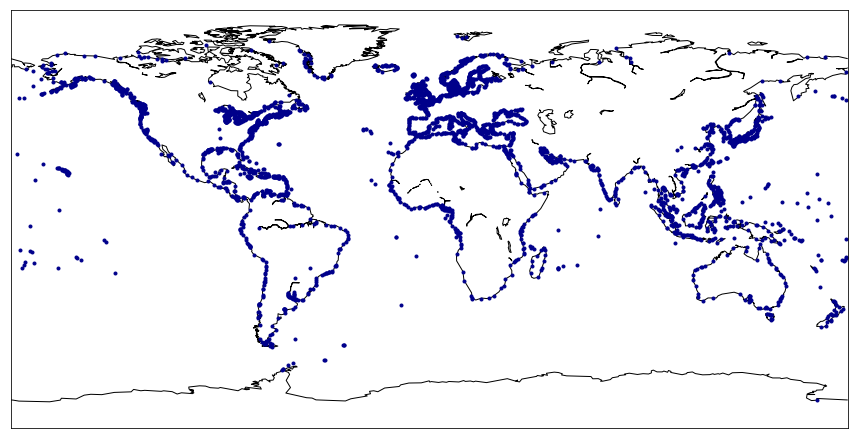

In [38]:
# Let's visualise the ports
# Plotting the civil airports

plt.figure(figsize=(15,15))
map = Basemap()
map.drawcoastlines()

for port in ports_1.index:
    map.plot(list(ports_1.loc[port].geometry.coords)[0][0],
            list(ports_1.loc[port].geometry.coords)[0][1],color='darkblue',marker='o',markersize=3)

plt.show()

In [39]:
ports_1.columns

Index(['INDEX_NO', 'REGION_NO', 'PORT_NAME', 'COUNTRY', 'LATITUDE',
       'LONGITUDE', 'LAT_DEG', 'LAT_MIN', 'LAT_HEMI', 'LONG_DEG', 'LONG_MIN',
       'LONG_HEMI', 'PUB', 'CHART', 'HARBORSIZE', 'HARBORTYPE', 'SHELTER',
       'ENTRY_TIDE', 'ENTRYSWELL', 'ENTRY_ICE', 'ENTRYOTHER', 'OVERHD_LIM',
       'CHAN_DEPTH', 'ANCH_DEPTH', 'CARGODEPTH', 'OIL_DEPTH', 'TIDE_RANGE',
       'MAX_VESSEL', 'HOLDGROUND', 'TURN_BASIN', 'PORTOFENTR', 'US_REP',
       'ETAMESSAGE', 'PILOT_REQD', 'PILOTAVAIL', 'LOC_ASSIST', 'PILOTADVSD',
       'TUGSALVAGE', 'TUG_ASSIST', 'PRATIQUE', 'SSCC_CERT', 'QUAR_OTHER',
       'COMM_PHONE', 'COMM_FAX', 'COMM_RADIO', 'COMM_VHF', 'COMM_AIR',
       'COMM_RAIL', 'CARGOWHARF', 'CARGO_ANCH', 'CARGMDMOOR', 'CARBCHMOOR',
       'CARICEMOOR', 'MED_FACIL', 'GARBAGE', 'DEGAUSS', 'DRTYBALLST',
       'CRANEFIXED', 'CRANEMOBIL', 'CRANEFLOAT', 'LIFT_100_', 'LIFT50_100',
       'LIFT_25_49', 'LIFT_0_24', 'LONGSHORE', 'ELECTRICAL', 'SERV_STEAM',
       'NAV_EQUIP', 'ELECREPAIR', '

In [40]:
ports_1.head()

,INDEX_NO,REGION_NO,PORT_NAME,COUNTRY,LATITUDE,LONGITUDE,LAT_DEG,LAT_MIN,LAT_HEMI,LONG_DEG,...,PROVISIONS,WATER,FUEL_OIL,DIESEL,DECKSUPPLY,ENG_SUPPLY,REPAIRCODE,DRYDOCK,RAILWAY,geometry
0,61090.0,61070.0,SHAKOTAN,RU,43.866667,146.833333,43.0,52.0,N,146.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (146.8333333333333 43.86666666666667)
1,61110.0,61100.0,MOMBETSU KO,JP,44.350000,143.350000,44.0,21.0,N,143.0,...,NaN,Y,NaN,Y,NaN,NaN,C,NaN,NaN,POINT (143.35 44.35)
2,61120.0,61100.0,ABASHIRI KO,JP,44.016667,144.283333,44.0,1.0,N,144.0,...,NaN,Y,NaN,Y,NaN,NaN,C,NaN,NaN,POINT (144.2833333333333 44.01666666666667)
3,61130.0,61100.0,NEMURO KO,JP,43.333333,145.583333,43.0,20.0,N,145.0,...,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,POINT (145.5833333333333 43.33333333333334)
4,61140.0,61100.0,HANASAKI KO,JP,43.283333,145.583333,43.0,17.0,N,145.0,...,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,POINT (145.5833333333333 43.28333333333333)


In [41]:
ports_1.shape

(3669, 79)

In [42]:
ports_1.RAILWAY.unique()

array(['NaN', 'M', 'L', 'S'], dtype=object)

In [43]:
ports_1.HARBORSIZE.unique()

array(['V', 'S', 'M', 'L', 'NaN'], dtype=object)

In [44]:
print('Distribution of ports in each size category:\n\n',
{size:sum([True if obs == size else False for obs in ports_1.HARBORSIZE]) for size in ports_1.HARBORSIZE.unique()})

Distribution of ports in each size category:

 {'V': 2153, 'S': 990, 'M': 361, 'L': 160, 'NaN': 5}


In [45]:
print('Distribution of ports with Railway access:\n\n',
{size:sum([True if obs == size else False for obs in ports_1.RAILWAY]) for size in ports_1.RAILWAY.unique()})

Distribution of ports with Railway access:

 {'NaN': 2159, 'M': 377, 'L': 146, 'S': 987}


## Joining the countries shapefile with the ports

In [46]:
IsoCodes = countries[['ISO_A2','ISO3','SOV_A3','NAME']].sort_values(by=['ISO_A2'])
IsoCodes = IsoCodes.reset_index(drop=True)

# Manually based on their SOV_A3 code
# Reference: https://www.iban.com/country-codes
# Not bullet proof, but it works for the purpose

for i in IsoCodes.index:
    if IsoCodes['ISO_A2'].loc[i]=='-99':
        #print(IsoCodes['ISO3'].loc[i][0:2])
        IsoCodes['ISO_A2'].loc[i] = IsoCodes['ISO3'].loc[i][0:2]
IsoCodes = IsoCodes.sort_values(by=['NAME'])
#IsoCodes = IsoCodes.drop_duplicates(['ISO_A2'])
IsoCodes = IsoCodes.set_index(['ISO_A2'])

In [47]:
iso3CodePorts = []
nameCountryPorts = []

for country in ports_1.COUNTRY:
    if country in list(IsoCodes.index):
        if country == 'AU':
            iso3CodePorts.append('AUS')
            nameCountryPorts.append('Australia')
        elif country == 'SO':
            iso3CodePorts.append('SOM')
            nameCountryPorts.append('Somalia')
        elif country == 'CY':
            iso3CodePorts.append('CYP')
            nameCountryPorts.append('Cyprus')
        else:
            iso3CodePorts.append(IsoCodes['ISO3'].loc[country])
            nameCountryPorts.append(IsoCodes['NAME'].loc[country])
    else:
        iso3CodePorts.append('None')
        nameCountryPorts.append('None')

In [48]:
ports_1['ISO3'] = np.array(iso3CodePorts)
ports_1['CountryName'] = np.array(nameCountryPorts)

In [49]:
# Joining together the ports with the country file
ports = gpd.sjoin(ports_1,countries,how='left')

# Selecting the columns of interest
ports = ports[['PORT_NAME','ISO3_left','CountryName','LATITUDE','LONGITUDE','HARBORSIZE','HARBORTYPE','RAILWAY','geometry']]

# Renaming the chosen columns
ports.columns=['port_name','iso3','country_name','latitude','longitude','harborsize','harbortype','railway','geometry']

In [50]:
ports.head()

,port_name,iso3,country_name,latitude,longitude,harborsize,harbortype,railway,geometry
0,SHAKOTAN,RUS,Russia,43.866667,146.833333,V,CN,NaN,POINT (146.8333333333333 43.86666666666667)
1,MOMBETSU KO,JPN,Japan,44.350000,143.350000,V,CB,NaN,POINT (143.35 44.35)
2,ABASHIRI KO,JPN,Japan,44.016667,144.283333,S,CB,NaN,POINT (144.2833333333333 44.01666666666667)
3,NEMURO KO,JPN,Japan,43.333333,145.583333,S,CB,NaN,POINT (145.5833333333333 43.33333333333334)
4,HANASAKI KO,JPN,Japan,43.283333,145.583333,V,CB,NaN,POINT (145.5833333333333 43.28333333333333)


### Investigating the ports without any country-classification

In [51]:
# How many ports do not have a ISO3 code?
sum([1 if iso == 'None' else 0 for iso in ports.iso3])

23

In [52]:
# Only continuing with the ports without country classification
portsNoCountry = ports[[True if iso == 'None' else False for iso in ports.iso3]]

In [53]:
print('The number of ports in each possible harbor size are:\n\n',
     {size:sum([True if harborsize == size else False for harborsize in ports.harborsize]) for\
     size in ports.harborsize.unique()})

The number of ports in each possible harbor size are:

 {'V': 2153, 'S': 990, 'M': 361, 'L': 160, 'NaN': 5}


In [54]:
print('The number of ports without a country is:\n\n',
      {size:sum([1 if iso == 'None' else 0 for iso in portsNoCountry[[True if portsize == size else False for \
                                                              portsize in portsNoCountry.harborsize]].iso3])\
        for size in portsNoCountry.harborsize.unique()})

The number of ports without a country is:

 {'V': 16, 'M': 4, 'S': 3}


For now, nothing is done about the ports with missing country classification, as the amount is to small compared to total number of ports. 
### Writing the files

In [55]:
gpdPorts = gpd.GeoDataFrame(ports,geometry=ports.geometry,crs = countries.crs)

In [56]:
# Based on this answer: https://gis.stackexchange.com/questions/159681/geopandas-cant-save-geojson
with open('Final Data/ports.geojson', 'w') as f:
    f.write(gpdPorts.to_json())

In [57]:
portsToSave = ports.drop(['geometry'],axis=1)
portsToSave.to_csv('Final Data/ports.csv')

### Potential Attributes

In [58]:
# The purpose below is to give an idea of the content of the potential attributes, which could be included for visualisation.
print('The excluded columns are:\n\n',
      list(ports_1.columns)[0:16]+list(ports_1.columns)[-4:],
     '\n\nThey are excluded because the already are included or because there is too many unique values.',
     '\n\nThe potentially interesting attributes are:\n\n',
      np.array(ports_1.columns)[16:-4])


The excluded columns are:

 ['INDEX_NO', 'REGION_NO', 'PORT_NAME', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'LAT_DEG', 'LAT_MIN', 'LAT_HEMI', 'LONG_DEG', 'LONG_MIN', 'LONG_HEMI', 'PUB', 'CHART', 'HARBORSIZE', 'HARBORTYPE', 'RAILWAY', 'geometry', 'ISO3', 'CountryName'] 

They are excluded because the already are included or because there is too many unique values. 

The potentially interesting attributes are:

 ['SHELTER' 'ENTRY_TIDE' 'ENTRYSWELL' 'ENTRY_ICE' 'ENTRYOTHER' 'OVERHD_LIM'
 'CHAN_DEPTH' 'ANCH_DEPTH' 'CARGODEPTH' 'OIL_DEPTH' 'TIDE_RANGE'
 'MAX_VESSEL' 'HOLDGROUND' 'TURN_BASIN' 'PORTOFENTR' 'US_REP' 'ETAMESSAGE'
 'PILOT_REQD' 'PILOTAVAIL' 'LOC_ASSIST' 'PILOTADVSD' 'TUGSALVAGE'
 'TUG_ASSIST' 'PRATIQUE' 'SSCC_CERT' 'QUAR_OTHER' 'COMM_PHONE' 'COMM_FAX'
 'COMM_RADIO' 'COMM_VHF' 'COMM_AIR' 'COMM_RAIL' 'CARGOWHARF' 'CARGO_ANCH'
 'CARGMDMOOR' 'CARBCHMOOR' 'CARICEMOOR' 'MED_FACIL' 'GARBAGE' 'DEGAUSS'
 'DRTYBALLST' 'CRANEFIXED' 'CRANEMOBIL' 'CRANEFLOAT' 'LIFT_100_'
 'LIFT50_100' 'LIFT_25_49

In [59]:
for potentialAtt in ports_1.columns:
    if potentialAtt in list(list(ports_1.columns)[16:-4]):
        print('\nThe name of the potential attribute is:  %s\nThe unique values are:\n\n'%(potentialAtt),
              ports_1[potentialAtt].unique())


The name of the potential attribute is:  SHELTER
The unique values are:

 ['G' 'F' 'E' 'P' 'N' 'NaN']

The name of the potential attribute is:  ENTRY_TIDE
The unique values are:

 ['NaN' 'N' 'Y']

The name of the potential attribute is:  ENTRYSWELL
The unique values are:

 ['NaN' 'Y' 'N']

The name of the potential attribute is:  ENTRY_ICE
The unique values are:

 ['NaN' 'Y' 'N']

The name of the potential attribute is:  ENTRYOTHER
The unique values are:

 ['NaN' 'Y' 'N']

The name of the potential attribute is:  OVERHD_LIM
The unique values are:

 ['NaN' 'Y' 'N']

The name of the potential attribute is:  CHAN_DEPTH
The unique values are:

 ['K' 'J' 'M' 'H' 'G' 'F' 'L' 'E' 'N' 'D' 'P' 'O' 'A' 'C' 'NaN' 'Q' 'B']

The name of the potential attribute is:  ANCH_DEPTH
The unique values are:

 ['G' 'J' 'K' 'L' 'E' 'F' 'H' 'D' 'B' 'A' 'NaN' 'O' 'N' 'C' 'M' 'P' 'Q']

The name of the potential attribute is:  CARGODEPTH
The unique values are:

 ['O' 'J' 'NaN' 'K' 'G' 'F' 'P' 'H' 'L' 'M' 'D' 'E'

### The below is some exploratory stats on potentailly interesting categories. It is not at such important unless new attributes/dimensions is of interest

We are interested in the largest ports around the world, namely 'M' and 'L'.

In [60]:
#sizeMLIndcies = [i for i,s in enumerate(ports_1.HARBORSIZE) if s in ('M','L')]
sizeMLPorts = ports_1[(ports_1.HARBORSIZE == 'M') | (ports_1.HARBORSIZE == 'L')]
sizeMLPorts = sizeMLPorts.reset_index(drop=True)

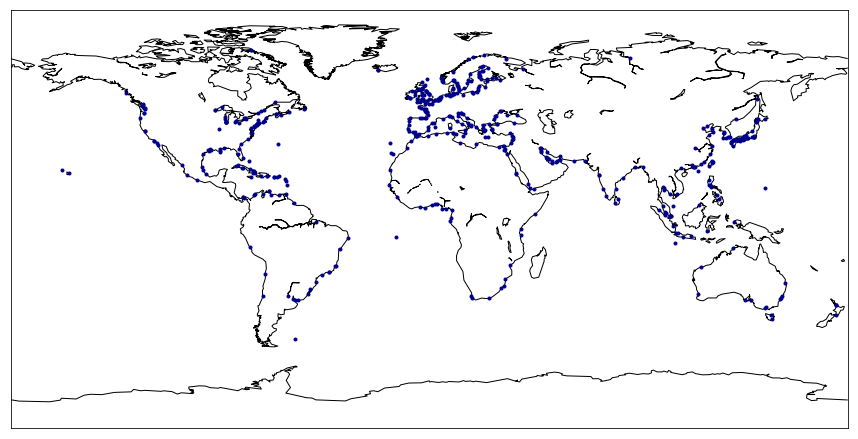

In [61]:
# Plot the V sized ports
# Plotting the civil airports

plt.figure(figsize=(15,15))
map = Basemap()
map.drawcoastlines()

for port in sizeMLPorts.index:
    map.plot(list(sizeMLPorts.loc[port].geometry.coords)[0][0],
            list(sizeMLPorts.loc[port].geometry.coords)[0][1],color='darkblue',marker='o',markersize=3)

plt.show()

In [62]:
sizeMLPorts.head()

,INDEX_NO,REGION_NO,PORT_NAME,COUNTRY,LATITUDE,LONGITUDE,LAT_DEG,LAT_MIN,LAT_HEMI,LONG_DEG,...,FUEL_OIL,DIESEL,DECKSUPPLY,ENG_SUPPLY,REPAIRCODE,DRYDOCK,RAILWAY,geometry,ISO3,CountryName
0,61160.0,61100.0,KUSHIRO KO,JP,42.983333,144.366667,42.0,59.0,N,144.0,...,Y,Y,Y,Y,C,NaN,M,POINT (144.3666666666667 42.98333333333333),JPN,Japan
1,61170.0,61100.0,MURORAN KO,JP,42.350000,140.966667,42.0,21.0,N,140.0,...,Y,NaN,NaN,NaN,A,M,L,POINT (140.9666666666667 42.35),JPN,Japan
2,61190.0,61100.0,HAKODATE KO,JP,41.783333,140.716667,41.0,47.0,N,140.0,...,Y,Y,Y,Y,B,M,L,POINT (140.7166666666667 41.78333333333333),JPN,Japan
3,61230.0,61100.0,OTARU KO,JP,43.200000,141.016667,43.0,12.0,N,141.0,...,Y,Y,Y,Y,C,NaN,S,POINT (141.0166666666667 43.2),JPN,Japan
4,61385.0,61100.0,KAWASAKI KO,JP,35.500000,139.766667,35.0,30.0,N,139.0,...,Y,Y,Y,NaN,A,M,M,POINT (139.7666666666667 35.5),JPN,Japan


#### Let's take a look at some cargo-related variables.

In [63]:
cargoColumns = [column for column in ports_1.columns if 'cargo' in column.lower()]

In [64]:
cargoColumns

['CARGODEPTH', 'CARGOWHARF', 'CARGO_ANCH']

In [65]:
for column in cargoColumns:
    print('%s\n' % column)
    print({uniVal:sum([True if obs == uniVal else False for obs in ports_1[column]]) \
           for uniVal in ports_1[column].unique()},'\n')

CARGODEPTH

{'O': 339, 'J': 325, 'NaN': 453, 'K': 392, 'G': 121, 'F': 49, 'P': 268, 'H': 154, 'L': 457, 'M': 450, 'D': 12, 'E': 38, 'B': 15, 'N': 533, 'A': 25, 'Q': 29, 'C': 9} 

CARGOWHARF

{'NaN': 875, 'Y': 2787, 'N': 7} 

CARGO_ANCH

{'Y': 1547, 'NaN': 2083, 'N': 39} 



And cargo variables for our sized-subset

In [66]:
for column in cargoColumns:
    print('%s\n' % column)
    print({uniVal:sum([True if obs == uniVal else False for obs in sizeMLPorts[column]]) \
           for uniVal in sizeMLPorts[column].unique()},'\n')

CARGODEPTH

{'G': 53, 'F': 18, 'B': 6, 'J': 83, 'L': 63, 'K': 70, 'H': 55, 'M': 64, 'N': 41, 'E': 21, 'D': 4, 'P': 3, 'NaN': 25, 'O': 10, 'C': 2, 'A': 3} 

CARGOWHARF

{'Y': 488, 'NaN': 33} 

CARGO_ANCH

{'NaN': 300, 'Y': 211, 'N': 10} 



### Country distribution

In [67]:
print({C:sum([True if obs == C else False for obs in sizeMLPorts.COUNTRY]) for C in sizeMLPorts.COUNTRY.unique()},'\n')
print('\nThere are %i countries in the subset' % len(sizeMLPorts.COUNTRY.unique()))

{'JP': 37, 'ZA': 5, 'MZ': 2, 'TZ': 1, 'KE': 1, 'SO': 1, 'GB': 31, 'NL': 6, 'BE': 3, 'RU': 9, 'KR': 7, 'CN': 14, 'CM': 1, 'GA': 2, 'SH': 1, 'NG': 3, 'GN': 1, 'PH': 6, 'CI': 1, 'GH': 1, 'TG': 1, 'BJ': 1, 'TN': 3, 'MO': 1, 'DZ': 3, 'MA': 4, 'MR': 1, 'SN': 1, 'TR': 6, 'SY': 2, 'HK': 1, 'TW': 4, 'MY': 7, 'TH': 3, 'KH': 1, 'VN': 1, 'LB': 2, 'LY': 2, 'GU': 1, 'UA': 3, 'GR': 8, 'US': 59, 'NZ': 3, 'BG': 1, 'RO': 2, 'AU': 13, 'IT': 16, 'HR': 2, 'MT': 1, 'ID': 9, 'CX': 1, 'ES': 17, 'GI': 1, 'PT': 4, 'SG': 3, 'FR': 18, 'EG': 6, 'YE': 3, 'LK': 2, 'IN': 7, 'BD': 1, 'IR': 4, 'PK': 2, 'IE': 4, 'AE': 5, 'BH': 3, 'SA': 1, 'KW': 2, 'IQ': 1, 'SD': 2, 'CO': 2, 'PA': 3, 'MX': 7, 'CA': 18, 'DE': 9, 'DK': 3, 'CL': 2, 'FI': 12, 'PE': 1, 'BR': 11, 'EE': 1, 'LV': 3, 'LT': 1, 'PL': 4, 'SE': 13, 'QA': 1, 'AR': 3, 'VE': 3, 'GY': 1, 'MQ': 1, 'IL': 1, 'CW': 2, 'GP': 1, 'DO': 2, 'IS': 2, 'NO': 11, 'PR': 3, 'VG': 1, 'AG': 1, 'CU': 9, 'HT': 1, 'BM': 1, 'BS': 1, 'UY': 1, 'FK': 1, 'JM': 1, 'TT': 1} 


There are 107 countr

### End of exploratory stats
## Let's take a look at the UK Data

In [116]:
# Opening the Open Document Sheet
doc = ezodf.opendoc('Data Sources/UK Port Freight (2)/port-freight-statistics-2017/port0400.ods')
# Data sheet
sheet = doc.sheets[2]

In [117]:
# A way to extract the data
start = time.time()
totalContent = []
for i,row in enumerate(sheet.rows()):
    if i == 0:
        columns = [cell.value for cell in row]
        
        columns = columns[:-1]
        
#         individualUKPortData = pd.DataFrame(columns = columns)
    if 0 < i:
    
        content = [cell.value for cell in row]
        totalContent.append(content[:-1])
        
        #individualUKPortData.loc[i] = content
individualUKPortData = pd.DataFrame(totalContent,columns = columns).fillna('None')
end = time.time()

print('The processing took %.3f seconds' % (end-start))

The processing took 4.621 seconds


In [118]:
individualUKPortData.shape
#individualUKPortData['Year'] = np.array(individualUKPortData['Year']).astype('datetime64')

(89893, 7)

In [119]:
individualUKPortData.loc[0:10]

,Reporting Port,Year,direction,Cargo_Code,Region,Type,Value (thousands)
0,Aberdeen,2017,1,13,Domestic traffic,Tonnage,330585
1,Aberdeen,2017,1,13,Domestic traffic,Tonnage,512503
2,Aberdeen,2017,1,13,European Union traffic,Tonnage,81612.7
3,Aberdeen,2017,1,13,Domestic traffic,Units,0
4,Aberdeen,2017,1,13,Domestic traffic,Units,0
5,Aberdeen,2017,1,13,European Union traffic,Units,0
6,Aberdeen,2017,2,13,Domestic traffic,Tonnage,11091.4
7,Aberdeen,2017,2,13,Domestic traffic,Tonnage,394723
8,Aberdeen,2017,2,13,European Union traffic,Tonnage,3881.98
9,Aberdeen,2017,2,13,Domestic traffic,Units,0


### Let's see some unique values, to get an idea of the opportunities that the data presents.

In [120]:
for column in individualUKPortData.columns:
    print('This is "%s"'% column,'\n\n','The unique values are:\n\n',individualUKPortData[column].unique(),'\n\n')

This is "Reporting Port" 

 The unique values are:

 ['Aberdeen' 'Belfast' 'Boston' 'Bristol' 'Cairnryan' 'Cardiff' 'Clyde'
 'Cromarty Firth' 'Dover' 'Dundee' 'Felixstowe' 'Fishguard' 'Forth'
 'Fowey' 'Glensanda' 'Goole' 'Great Yarmouth' 'Grimsby & Immingham'
 'Harwich' 'Heysham' 'Holyhead' 'Hull' 'Ipswich'
 'Kilroot Power Station Jetty' 'Larne' 'Liverpool' 'Loch Ryan' 'London'
 'Londonderry' 'Manchester' 'Medway' 'Milford Haven' 'Newhaven' 'Newport'
 'Orkney' 'Peterhead' 'Plymouth' 'Poole' 'Port Talbot' 'Portsmouth'
 'Ramsgate' 'River Trent' 'Rivers Hull & Humber' 'Shoreham' 'Southampton'
 'Sullom Voe' 'Sunderland' 'Swansea' 'Tees & Hartlepool' 'Tyne'
 'Warrenpoint' 'Stranraer' 'Fleetwood' 'None'] 


This is "Year" 

 The unique values are:

 [2017.0 2016.0 2015.0 2014.0 2013.0 2012.0 2011.0 2010.0 2009.0 2008.0
 2007.0 2006.0 2005.0 2004.0 2003.0 2002.0 2001.0 2000.0 'None'] 


This is "direction" 

 The unique values are:

 [1.0 2.0 'None'] 


This is "Cargo_Code" 

 The unique valu

From the above, it seems natural to consider the direction and the region for each port, as we already are restricted on the year.

In [121]:
individualUKPortData2017 = individualUKPortData[individualUKPortData.Year == 2017]
print(individualUKPortData2017.shape)

(4330, 7)


In [124]:
portsUK = pd.DataFrame(index=individualUKPortData2017['Reporting Port'].unique())

dataholder = [[] for i in np.arange(6)] # <- because there are 3 unique values in 'Regions' and 2 unique values in 'Directions'
#                                            plus a total column
# Excluding the 'None'
regions = [region for region in individualUKPortData2017.Region.unique() if region != 'None']

j = 0

for region in regions:
    temp = individualUKPortData2017[individualUKPortData2017.Region==region]
    
    for port in individualUKPortData2017['Reporting Port'].unique():
        # Inwards
        dataholder[j].append(round(sum(temp[(temp['Reporting Port'] == port) & (temp.direction == 1)\
                                           & (temp.Type == 'Tonnage')]['Value (thousands)'])/1000,3))

        # Outwards
        dataholder[j+1].append(round(sum(temp[(temp['Reporting Port'] == port) & (temp.direction == 2)\
                                           & (temp.Type == 'Tonnage')]['Value (thousands)'])/1000,3))
        #dataholder[-1].append(dataholder[j][-1]+dataholder[j+1][-1])
    j += 2

In [126]:
for column in np.arange(len(dataholder)):
    portsUK[str(column)] = dataholder[column]

# print the regions, to set correct columns
print(regions)

['Domestic traffic', 'European Union traffic', 'Non-EU Foreign traffic']


In [127]:
portsUK.columns = ['domestic_traffic_inwards','domestic_traffic_outwards',
                  'european_union_traffic_inwards','european_union_traffic_outwards',
                  'non-eu_foreign_traffic_inwards','non-eu_foreign_traffic_outwards']

In [128]:
portsUK

,domestic_traffic_inwards,domestic_traffic_outwards,european_union_traffic_inwards,european_union_traffic_outwards,non-eu_foreign_traffic_inwards,non-eu_foreign_traffic_outwards
Aberdeen,1536.467,1796.029,238.273,201.741,172.942,112.968
Belfast,5998.598,5767.772,2662.600,1109.972,2512.152,174.836
Boston,0.000,0.000,601.379,116.588,18.393,2.052
Bristol,1906.920,145.195,1611.869,677.590,3686.488,712.625
Cairnryan,1399.104,1448.364,0.000,0.000,0.000,0.000
Cardiff,1046.743,54.824,346.492,37.398,88.082,0.000
Clyde,752.246,824.259,1182.040,1158.429,4565.309,382.849
Cromarty Firth,54.521,21.417,90.180,46.479,13.390,0.684
Dover,4.083,20.298,15287.804,10668.650,241.143,0.728
Dundee,18.455,1.846,419.428,64.350,61.840,0.442


In [133]:
# Adding the total column
portsUK['Total'] = portsUK.sum(axis=1)

### It is now time to attach geometries to the constructed data

In [134]:
print('The number of UK ports present in the global ports file:', len([ukport for ukport in portsUK.index if \
 any([True if ukport.lower() in globalports.lower() else False for globalports in ports.port_name])]),'\n')
print('The ports present are:\n')
[print(ukport) for ukport in portsUK.index if \
 any([True if ukport.lower() in globalports.lower() else False for globalports in ports.port_name])]
print()

The number of UK ports present in the global ports file: 39 

The ports present are:

Aberdeen
Belfast
Boston
Bristol
Cardiff
Clyde
Dover
Dundee
Felixstowe
Fishguard
Fowey
Glensanda
Goole
Great Yarmouth
Harwich
Heysham
Holyhead
Hull
Ipswich
Larne
Liverpool
London
Londonderry
Manchester
Milford Haven
Newhaven
Newport
Peterhead
Plymouth
Poole
Port Talbot
Portsmouth
Ramsgate
Shoreham
Southampton
Sullom Voe
Sunderland
Swansea
Tyne



### Time to subset the UK-ports data

In [135]:
portsUKinGlobal = portsUK[[True if any([True if ukport.lower() in globalports.lower()\
                                        else False for globalports in ports.port_name]) else False for ukport in portsUK.index]]
portsUKinGlobal = portsUKinGlobal.sort_index()

In [136]:
portsUKinGlobal

,domestic_traffic_inwards,domestic_traffic_outwards,european_union_traffic_inwards,european_union_traffic_outwards,non-eu_foreign_traffic_inwards,non-eu_foreign_traffic_outwards,Total
Aberdeen,1536.467,1796.029,238.273,201.741,172.942,112.968,4058.420
Belfast,5998.598,5767.772,2662.600,1109.972,2512.152,174.836,18225.930
Boston,0.000,0.000,601.379,116.588,18.393,2.052,738.412
Bristol,1906.920,145.195,1611.869,677.590,3686.488,712.625,8740.687
Cardiff,1046.743,54.824,346.492,37.398,88.082,0.000,1573.539
Clyde,752.246,824.259,1182.040,1158.429,4565.309,382.849,8865.132
Dover,4.083,20.298,15287.804,10668.650,241.143,0.728,26222.706
Dundee,18.455,1.846,419.428,64.350,61.840,0.442,566.361
Felixstowe,226.259,290.304,4906.184,2914.107,12821.984,7868.952,29027.790
Fishguard,11.329,0.000,211.404,157.838,0.000,0.000,380.571


### Time to subset the global-ports data, in order to merge the two subsetted DataFrames

In [137]:
portsGlobalInUK = ports[([True if any([True if ukport.lower() in globalport.lower()\
                                        else False for ukport in portsUK.index]) \
                         else False for globalport in ports.port_name]) & (ports.iso3 == 'GBR')]

portsGlobalInUK = portsGlobalInUK.sort_values(by=['port_name'])
portsGlobalInUK = portsGlobalInUK.reset_index(drop=True)
portsGlobalInUK = portsGlobalInUK.set_index(portsUKinGlobal.index)

# Joining together the subsetted dataframes

UKports = portsUKinGlobal.join(portsGlobalInUK)

In [138]:
UKports

,domestic_traffic_inwards,domestic_traffic_outwards,european_union_traffic_inwards,european_union_traffic_outwards,non-eu_foreign_traffic_inwards,non-eu_foreign_traffic_outwards,Total,port_name,iso3,country_name,latitude,longitude,harborsize,harbortype,railway,geometry
Aberdeen,1536.467,1796.029,238.273,201.741,172.942,112.968,4058.420,ABERDEEN,GBR,United Kingdom,57.150000,-2.083333,M,RB,NaN,POINT (-2.083333333333333 57.15)
Belfast,5998.598,5767.772,2662.600,1109.972,2512.152,174.836,18225.930,BELFAST,GBR,United Kingdom,54.616667,-5.900000,L,RB,S,POINT (-5.9 54.61666666666667)
Boston,0.000,0.000,601.379,116.588,18.393,2.052,738.412,BOSTON,GBR,United Kingdom,52.966667,-0.016667,S,RT,S,POINT (-0.01666666666666667 52.96666666666667)
Bristol,1906.920,145.195,1611.869,677.590,3686.488,712.625,8740.687,BRISTOL,GBR,United Kingdom,51.466667,-2.633333,M,RT,S,POINT (-2.633333333333333 51.46666666666667)
Cardiff,1046.743,54.824,346.492,37.398,88.082,0.000,1573.539,CARDIFF,GBR,United Kingdom,51.450000,-3.166667,M,CT,S,POINT (-3.166666666666667 51.45)
Clyde,752.246,824.259,1182.040,1158.429,4565.309,382.849,8865.132,DOVER HARBOR,GBR,United Kingdom,51.116667,1.333333,S,CB,M,POINT (1.333333333333333 51.11666666666667)
Dover,4.083,20.298,15287.804,10668.650,241.143,0.728,26222.706,DUNDEE,GBR,United Kingdom,56.466667,-2.950000,L,RB,NaN,POINT (-2.95 56.46666666666667)
Dundee,18.455,1.846,419.428,64.350,61.840,0.442,566.361,FELIXSTOWE,GBR,United Kingdom,51.950000,1.316667,V,RN,S,POINT (1.316666666666667 51.95)
Felixstowe,226.259,290.304,4906.184,2914.107,12821.984,7868.952,29027.790,FISHGUARD,GBR,United Kingdom,52.016667,-4.983333,S,CB,S,POINT (-4.983333333333333 52.01666666666667)
Fishguard,11.329,0.000,211.404,157.838,0.000,0.000,380.571,FOWEY HARBOUR,GBR,United Kingdom,50.333333,-4.633333,S,RN,M,POINT (-4.633333333333333 50.33333333333334)


### Writing the files

In [139]:
gpdUKPorts = gpd.GeoDataFrame(UKports,geometry=UKports.geometry,crs = countries.crs)

In [140]:
# Based on this answer: https://gis.stackexchange.com/questions/159681/geopandas-cant-save-geojson
with open('Final Data/UKports.geojson', 'w') as f:
    f.write(gpdUKPorts.to_json())

In [141]:
UKportsToSave = UKports.drop(['geometry'],axis=1)
UKportsToSave.to_csv('Final Data/UKports.csv')

## Trade flows (Global)

In [84]:
tradeFlows = pd.read_csv('StructuredData.csv',parse_dates=['date'],index_col =0)
# Limiting the data to only 2017 for now.
tradeFlows = tradeFlows[((tradeFlows.date >='2017-01-01') & (tradeFlows.date <= '2017-12-01')) &\
                       (tradeFlows['product'] != 'TOTAL')]
tradeFlows = tradeFlows.reset_index(drop=True)
tradeFlows['product'] = tradeFlows['product'].astype(int)

In [85]:
tradeFlows.head()

,trade_value,product,product_description,date,partner,indicator_type,reporter,reporter_ISO
0,0.770370,1,Animals; live,2017-01-01,World,Export,Albania,ALB
1,0.044056,1,Animals; live,2017-01-01,World,Export,Algeria,DZA
2,0.071136,1,Animals; live,2017-01-01,World,Export,Andorra,AND
3,1242.319413,1,Animals; live,2017-01-01,World,Export,Australia,AUS
4,188.706390,1,Animals; live,2017-01-01,World,Export,Austria,AUT


In [86]:
######################### Restructuring data ###########################
# _______________________________________________________________________

####################### Standard 15 categories #########################

# hsMainCategories = ['animals_&_animal_products','vegetable_products','foodstuffs','mineral_products',
#                     'chemicals_&_allied_industries','Plastics/Rubbers','raw_hides,_skins,_leather_&_furs',
#                    'wood_&_wood_products','textiles','footwear_/_headgear','stone_/_glass','metals',
#                    'machinery_/_electrical','transportation','miscellaneous','all_commodities']

# hsMain = [(1,5),(6,15),(16,24),(25,27),(28,38),(39,40),(41,43),(44,49),
#           (50,63),(64,67),(68,71),(72,83),(84,85),(86,89),(90,97),'TOTAL']

####################### Reduced set of categories #######################

hsMainCategories = ['organic_products','chemicals','material','clothing','metals',
                    'technical','transportation','miscellaneous_goods','all_commodities']

hsMain = [(1,24),(28,38),[(25,27),(39,56),(68,71)],(57,67),(72,83),(84,85),(86,89),(90,97),'TOTAL']

exports = [[] for i in np.arange(0,len(hsMain))]
imports = [[] for i in np.arange(0,len(hsMain))]

for country in tradeFlows.reporter.unique():
    
    # Only considering the relevant observations
    tempTradeFlows = tradeFlows[tradeFlows.reporter==country]
    tempTradeFlows = tempTradeFlows.reset_index(drop=True)
    for i,categories in enumerate(hsMain):
        #print(categories)
        if type(categories) != list: 
            # First export
            if type(categories) != str:

                exports[i].append(round(sum(tempTradeFlows[((tempTradeFlows['product'] >= categories[0]) &\
                                           (tempTradeFlows['product'] <= categories[1])) &\
                                           (tempTradeFlows.indicator_type == 'Export')].trade_value),3))
            else:
                exports[i].append(round(sum(tempTradeFlows[tempTradeFlows.indicator_type=='Export'].trade_value),3))

            # Then import
            if type(categories) != str:

                imports[i].append(round(sum(tempTradeFlows[((tempTradeFlows['product'] >= categories[0]) &\
                                            (tempTradeFlows['product'] <= categories[1])) &\
                                            (tempTradeFlows.indicator_type == 'Import')].trade_value),3))
            else:
                imports[i].append(round(sum(tempTradeFlows[tempTradeFlows.indicator_type=='Import'].trade_value),3))
        
        elif type(categories) == list:
            #Extention
            tempExport = 0
            tempImport = 0
            
            for subCategory in categories:
                if type(subCategory) == str:
                    raise ValueError('You cannot include "Total" in a list of tuples.')
                
                tempExport += round(sum(tempTradeFlows[((tempTradeFlows['product'] >= subCategory[0]) &\
                                           (tempTradeFlows['product'] <= subCategory[1])) &\
                                           (tempTradeFlows.indicator_type == 'Export')].trade_value),3)
                                      
                tempImport += round(sum(tempTradeFlows[((tempTradeFlows['product'] >= subCategory[0]) &\
                                            (tempTradeFlows['product'] <= subCategory[1])) &\
                                            (tempTradeFlows.indicator_type == 'Import')].trade_value),3)
            # Appending at the end
            exports[i].append(tempExport)
            imports[i].append(tempImport)
                
#         else:
#             raise ValueError('The format of the positions are wrong, either provide it as a list of tuples or a single tuple')

combined = exports+imports

In [87]:
tradeFlowData = pd.DataFrame(index = tradeFlows.reporter.unique(),
                             columns=[category+'_export' for category in hsMainCategories]+\
                                     [category+'_import' for category in hsMainCategories])
for i,category in enumerate(combined):
    tradeFlowData.iloc[:,i] = category

In [88]:
tradeFlowData['ISO3'] = tradeFlows.reporter_ISO.unique()

In [89]:
tradeFlowData.head()

,organic_products_export,chemicals_export,material_export,clothing_export,metals_export,technical_export,transportation_export,miscellaneous_goods_export,all_commodities_export,organic_products_import,chemicals_import,material_import,clothing_import,metals_import,technical_import,transportation_import,miscellaneous_goods_import,all_commodities_import,ISO3
Albania,253.592,20.481,504.829,987.659,351.251,106.350,20.772,55.395,2300.329,902.405,484.346,1466.302,571.808,526.633,767.239,366.151,189.804,5274.687,ALB
Algeria,352.286,775.930,33964.004,0.811,11.783,59.750,21.057,5.497,35191.117,9415.691,4257.590,7163.324,939.355,6513.290,11991.787,4394.323,1377.655,46053.016,DZA
Andorra,0.857,1.938,20.368,9.705,5.748,35.502,23.803,19.403,117.324,339.174,180.473,269.969,162.165,38.289,177.221,187.202,122.333,1476.827,AND
Australia,33023.048,11404.581,154373.943,456.601,10231.289,7665.664,3586.913,3858.712,224600.751,15334.305,19711.056,50708.185,10612.758,10622.221,52992.304,40094.228,17040.121,217115.178,AUS
Austria,12558.670,17692.036,28443.476,4700.658,22400.738,45032.580,19517.264,9506.904,159852.324,13515.714,18451.627,36268.453,9584.452,18119.193,37796.299,22006.902,10677.261,166419.902,AUT


## Global Freight

In [90]:
globalFreight.shape

(264, 64)

In [91]:
tradeFlowData.shape

(143, 19)

In [92]:
# Let's examine some of the variables which could be expected to have not variation.
print('All Columns: \n\n',globalFreight.columns,'\n')
print('Unique values in "Indicator Name": ',globalFreight['Indicator Name'].unique(),'\n')
print('Unique values in "Indicator Code": ',globalFreight['Indicator Code'].unique(),'\n')

All Columns: 

 Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', 'Unnamed: 63'],
      dtype='object') 

Unique values in "Indicator Name":  ['Air transport, freight (million ton-km)'] 

Unique values in "Indicator Code":  ['IS.AIR.GOOD.MT.K1'] 



In [93]:
globalFreight = globalFreight[['Country Name','Country Code','2013','2014','2015','2016','2017']]

In [94]:
globalFreight.head()

,Country Name,Country Code,2013,2014,2015,2016,2017
0,Aruba,ABW,0.000000,0.000000,0.000000,0.000000,0.000000
1,Afghanistan,AFG,84.621216,34.283472,33.102039,29.010881,25.144211
2,Angola,AGO,70.431000,65.517000,46.043000,43.940435,67.913802
3,Albania,ALB,0.000000,0.000000,0.000000,0.000000,0.000000
4,Andorra,AND,0.000000,0.000000,0.000000,0.000000,0.000000


In [95]:
print('Countries with a value of zero:\n')
print({year:sum([1 if value == float(0) else 0 for value in globalFreight[year]])\
       for year in ['2013','2014','2015','2016','2017']})
print('\nIn percentage of the number of countries available: \n')
print({year:round(sum([1 if value == float(0) else 0 for value in globalFreight[year]])/globalFreight.shape[0],3)\
       for year in ['2013','2014','2015','2016','2017']})

Countries with a value of zero:

{'2013': 75, '2014': 77, '2015': 80, '2016': 81, '2017': 86}

In percentage of the number of countries available: 

{'2013': 0.284, '2014': 0.292, '2015': 0.303, '2016': 0.307, '2017': 0.326}


## Global Passengers

In [96]:
globalPassengers.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,"Air transport, passengers carried",IS.AIR.PSGR,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,0.0,0.0,0.0,0.0,0.0,0.0,...,1999127.0,2.279341e+06,1.737962e+06,2044188.0,2209428.0,1929907.0,1917924.0,1858558.0,0.0,0.0
2,Angola,AGO,"Air transport, passengers carried",IS.AIR.PSGR,0.0,0.0,0.0,0.0,0.0,0.0,...,1010194.0,9.877980e+05,1.132424e+06,1321872.0,1409952.0,1244491.0,1482546.0,1581201.0,0.0,0.0
3,Albania,ALB,"Air transport, passengers carried",IS.AIR.PSGR,0.0,0.0,0.0,0.0,0.0,0.0,...,768533.0,8.297789e+05,8.143397e+05,865848.0,151632.0,0.0,26634.0,103151.0,0.0,0.0
4,Andorra,AND,"Air transport, passengers carried",IS.AIR.PSGR,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# Let's examine some of the variables which could be expected to have not variation.
print('All Columns: \n\n',globalPassengers.columns,'\n')
print('Unique values in "Indicator Name": ',globalPassengers['Indicator Name'].unique(),'\n')
print('Unique values in "Indicator Code": ',globalPassengers['Indicator Code'].unique(),'\n')

All Columns: 

 Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', 'Unnamed: 63'],
      dtype='object') 

Unique values in "Indicator Name":  ['Air transport, passengers carried'] 

Unique values in "Indicator Code":  ['IS.AIR.PSGR'] 



In [98]:
globalPassengers = globalPassengers[['Country Name','Country Code','2013','2014','2015','2016','2017']]

In [99]:
globalPassengers.head()

,Country Name,Country Code,2013,2014,2015,2016,2017
0,Aruba,ABW,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,AFG,2044188.0,2209428.0,1929907.0,1917924.0,1858558.0
2,Angola,AGO,1321872.0,1409952.0,1244491.0,1482546.0,1581201.0
3,Albania,ALB,865848.0,151632.0,0.0,26634.0,103151.0
4,Andorra,AND,0.0,0.0,0.0,0.0,0.0


In [100]:
print('Countries with a value of zero:\n')
print({year:sum([1 if value == float(0) else 0 for value in globalPassengers[year]])\
       for year in ['2013','2014','2015','2016','2017']})
print('\nIn percentage of the number of countries available: \n')
print({year:round(sum([1 if value == float(0) else 0 for value in globalPassengers[year]])/globalPassengers.shape[0],3)\
       for year in ['2013','2014','2015','2016','2017']})

Countries with a value of zero:

{'2013': 62, '2014': 63, '2015': 64, '2016': 63, '2017': 65}

In percentage of the number of countries available: 

{'2013': 0.235, '2014': 0.239, '2015': 0.242, '2016': 0.239, '2017': 0.246}


### Let's compare with the 'countries' shapefile

In [101]:
print('The number of matching entities in the global freight data are:',sum([1 if country in list(countries.NAME_EN) else 0\
                                                                        for country in globalFreight['Country Name']]),'\n')
print('The number of matching entities in the global passenger data are:',sum([1 if country in list(countries.NAME_EN) else 0\
                                                                            for country in globalPassengers['Country Name']]))

The number of matching entities in the global freight data are: 179 

The number of matching entities in the global passenger data are: 179


### Let's compare with the airport shapefile

In [102]:
print('The number of matching entities in the global freight data are:',sum([1 if country in list(airports.NAME) else 0\
                                                                        for country in globalFreight['Country Name']]),'\n')
print('The number of matching entities in the global passenger data are:',sum([1 if country in list(airports.NAME) else 0\
                                                                            for country in globalPassengers['Country Name']]))

The number of matching entities in the global freight data are: 151 

The number of matching entities in the global passenger data are: 151


## Merging the global freight, passenger and trade flow data together

In [103]:
merged1 = tradeFlowData.merge(globalFreight[['Country Code','2017']],left_on = 'ISO3',right_on='Country Code')
merged2 = merged1.merge(globalPassengers[['Country Code','2017']],left_on='ISO3',right_on='Country Code')

In [104]:
merged2 = merged2.drop(['Country Code_x','Country Code_y'],axis=1)

In [105]:
newColumns=list(merged2.columns)
# Changing names on the merged columns
newColumns[-2] = 'freight_2017'
newColumns[-1] = 'passengers_2017'

# Replacing
merged2.columns = newColumns

In [106]:
combinedCountryData = merged2.merge(countries[[True if country in list(merged2.ISO3) else\
                                               False for country in countries.ISO_A3]][['ISO_A3','geometry']],
                                   left_on = 'ISO3',right_on='ISO_A3')
combinedCountryData = combinedCountryData.drop(['ISO_A3'],axis=1)

In [107]:
combinedCountryData.columns

Index(['organic_products_export', 'chemicals_export', 'material_export',
       'clothing_export', 'metals_export', 'technical_export',
       'transportation_export', 'miscellaneous_goods_export',
       'all_commodities_export', 'organic_products_import', 'chemicals_import',
       'material_import', 'clothing_import', 'metals_import',
       'technical_import', 'transportation_import',
       'miscellaneous_goods_import', 'all_commodities_import', 'ISO3',
       'freight_2017', 'passengers_2017', 'geometry'],
      dtype='object')

In [108]:
gpdCombinedData = gpd.GeoDataFrame(combinedCountryData,geometry=combinedCountryData.geometry)

In [109]:
len(tradeFlows.reporter_ISO.unique())

143

In [110]:
# Based on this answer: https://gis.stackexchange.com/questions/159681/geopandas-cant-save-geojson
with open('Final Data/globalData_reCat.geojson', 'w') as f:
    f.write(gpdCombinedData.to_json())

In [111]:
combinedCountryData = combinedCountryData.drop(['geometry'],axis=1)
combinedCountryData.to_csv('Final Data/globalData_reCat.csv')

In [112]:
combinedCountryData.loc[0:10]

,organic_products_export,chemicals_export,material_export,clothing_export,metals_export,technical_export,transportation_export,miscellaneous_goods_export,all_commodities_export,organic_products_import,...,material_import,clothing_import,metals_import,technical_import,transportation_import,miscellaneous_goods_import,all_commodities_import,ISO3,freight_2017,passengers_2017
0,253.592,20.481,504.829,987.659,351.251,106.350,20.772,55.395,2300.329,902.405,...,1466.302,571.808,526.633,767.239,366.151,189.804,5274.687,ALB,0.000000,103151.0
1,352.286,775.930,33964.004,0.811,11.783,59.750,21.057,5.497,35191.117,9415.691,...,7163.324,939.355,6513.290,11991.787,4394.323,1377.655,46053.016,DZA,24.803750,6241924.0
2,0.857,1.938,20.368,9.705,5.748,35.502,23.803,19.403,117.324,339.174,...,269.969,162.165,38.289,177.221,187.202,122.333,1476.827,AND,0.000000,0.0
3,33023.048,11404.581,154373.943,456.601,10231.289,7665.664,3586.913,3858.712,224600.751,15334.305,...,50708.185,10612.758,10622.221,52992.304,40094.228,17040.121,217115.178,AUS,1982.586171,74257326.0
4,12558.670,17692.036,28443.476,4700.658,22400.738,45032.580,19517.264,9506.904,159852.324,13515.714,...,36268.453,9584.452,18119.193,37796.299,22006.902,10677.261,166419.902,AUT,391.268000,16171640.0
5,627.727,29.177,970.364,127.550,268.611,37.937,13.837,62.782,2137.986,715.074,...,1297.731,216.416,290.948,624.895,150.053,189.427,3891.287,ARM,0.000000,0.0
6,45211.494,97624.075,107846.524,19179.515,32996.214,44920.753,51437.353,21388.500,420604.428,40159.410,...,108396.769,14811.276,29780.797,50650.807,54609.204,20123.084,402069.227,BEL,1513.990699,13676844.0
7,553.159,546.846,1605.142,706.944,1101.825,737.666,192.192,833.940,6277.713,1798.239,...,3331.136,655.871,1123.373,1454.895,724.903,378.014,10434.534,BIH,0.000000,0.0
8,79262.296,10629.111,70037.759,1697.351,16314.529,17284.000,19844.882,2528.749,217598.677,11204.848,...,38814.821,3042.018,8638.579,38129.657,12779.654,6828.796,150749.452,BRA,1736.549227,96395709.0
9,11.012,201.895,5010.721,12.589,33.022,100.521,38.679,151.408,5559.846,466.491,...,602.671,64.301,489.549,755.337,298.003,168.273,3075.377,BRN,132.612000,1172201.0
